We are provided with a dataset of Walmart Store level Sales. The requirement is to predict store level sales for next 12 weeks. Here we will use time siries analysis  

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [26]:
walmart = pd.read_csv('/content/Walmart DataSet.csv')
walmart.sample(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1333,10,24-12-2010,3749057.69,0,57.06,3.236,126.983581,9.003
2689,19,20-04-2012,1255087.26,0,55.20,4.170,137.923067,8.150
5765,41,17-12-2010,1627904.68,0,31.51,2.778,191.030338,7.508
842,6,13-07-2012,1588142.26,0,80.27,3.256,223.533282,5.668
4872,35,16-04-2010,1084487.55,0,54.95,2.899,135.827250,9.051


In [4]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [27]:
walmart['Date'] = pd.to_datetime(walmart['Date'], format='%d-%m-%Y')

Use predictive modeling techniques to forecast the sales for each store for the next 12
weeks.

---



In [30]:
databystore = walmart.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

In [28]:
def storedata(storeid):
  store_data = databystore[databystore['Store'] == storeid]
  store_data = store_data.set_index('Date')
  store_data = store_data.drop('Store', axis=1)
  return store_data

In [ ]:
storedata(4)

,Weekly_Sales
Date,
2010-02-05,2135143.87
2010-02-12,2188307.39
2010-02-19,2049860.26
2010-02-26,1925728.84
2010-03-05,1971057.44
...,...
2012-09-28,2027620.23
2012-10-05,2209835.43
2012-10-12,2133026.07


In [31]:
store_data_4 = databystore[databystore['Store'] == 4]

In [32]:
store_data_4 = store_data_4.set_index('Date')
store_data_4 = store_data_4.drop('Store', axis=1)

In [33]:
store_data_4.shape

(143, 1)

We are going to use time series modelling to predict the future sales. Before applying ARIMA OR SARIMAX we have to find the order(p, d, q) and seasonal order (p, d, q, S)

We will find the orders using
1. Differencing (d)
2. Using ACF plot (q)
3. Using PACF plot (p)
4. Using visualization for the weekly data (S)

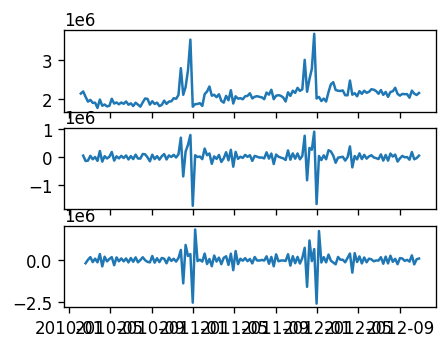

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(4,3)})


# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)

axes[0].plot(store_data_4['Weekly_Sales'])

# 1st Differencing
axes[1].plot(store_data_4['Weekly_Sales'].diff())

# 2nd Differencing
axes[2].plot(store_data_4['Weekly_Sales'].diff().diff())

plt.show()

From the above analysis We will take : d = 1

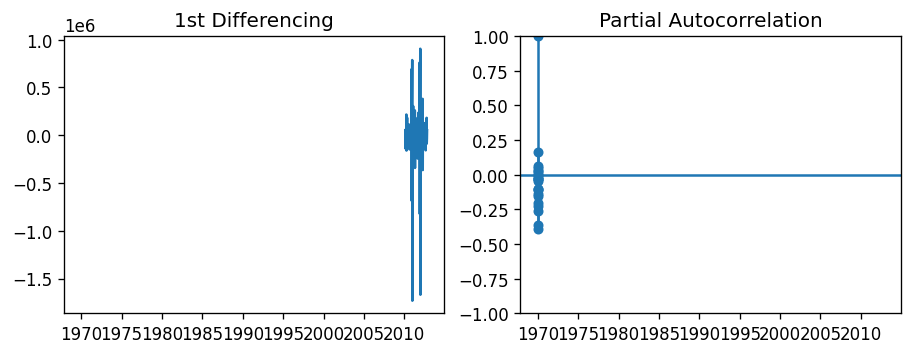

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(store_data_4['Weekly_Sales'].diff()); axes[0].set_title('1st Differencing')
plot_pacf(store_data_4['Weekly_Sales'].diff().dropna(), ax=axes[1])

plt.show()

From the above analysis We will take : p = 1

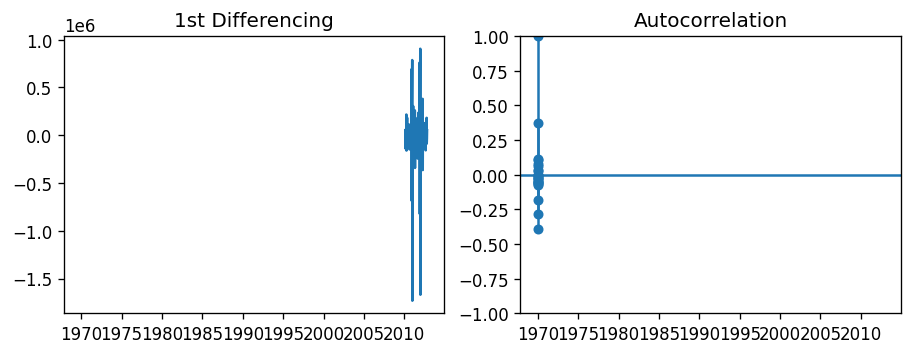

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(store_data_4['Weekly_Sales'].diff()); axes[0].set_title('1st Differencing')
plot_acf(store_data_4['Weekly_Sales'].diff().dropna(), ax=axes[1])

plt.show()

From the above analysis We will take : q = 1

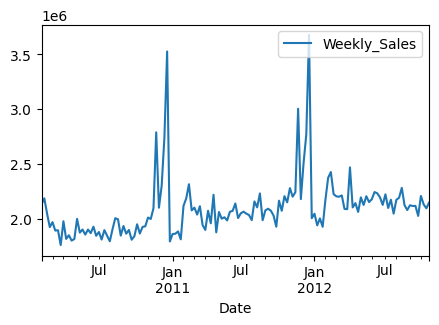

In [34]:
store_data_4.plot(figsize=(5,3))
plt.show()

From the above analysis it is clear that there is a seasonality on yearly basis around january of each year. Since its a weekly data with yearly seasonality we will take : S = 52

In [5]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


Here we will try to create a function which can predict the store level sales for next 12 weeks

- The store id will be provided as input. First we will fetch only the store data

- Then we will create a new dataset containing only the Sales column with date as index

- Then we will apply sarimax and fit the store data

- Then we forecast the store sales for next 12 weeks

- Then we plot the historical data along with forecast data and compare through visualization

In [22]:
def predict_store_sales_sarimax(data, store_id, plot=True):

 # Filter data for the specified store
  store_data = data[data['Store'] == store_id].copy()
  store_data['Date'] = pd.to_datetime(store_data['Date'], format='%d-%m-%Y')
  store_data.set_index('Date', inplace=True)
  ts = store_data['Weekly_Sales']

# From the previous analysis of acf and pacf plot we have found the order and seasonal order
  order = (1, 1, 1)
  seasonal_order =(1, 1, 1, 52)

  from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 2: Fit SARIMAX model
  sarimax_model = SARIMAX(
        ts,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

  results = sarimax_model.fit(disp=False)

# Step 3: Forecast next 12 weeks
  forecastSarima = results.predict(start = len(ts),
                          end = (len(ts)-1) + 12,
                          typ = 'levels').rename('forecastSarima')

# Plot the prediction for next 12 weeks along with historical trend
  ts.plot(figsize = (6, 4), legend = True)
  forecastSarima.plot(legend = True)
  plt.title(f'Store {store_id} Sales Forecast 12 weeks')
  plt.ylabel('Sales')
  plt.legend()
  plt.grid()
  plt.show()

  return None

In [11]:
walmart['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

Here we are using the created function where we provide the dataset and the store id as input

When the function is run, the forecast is visualized with a plot

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


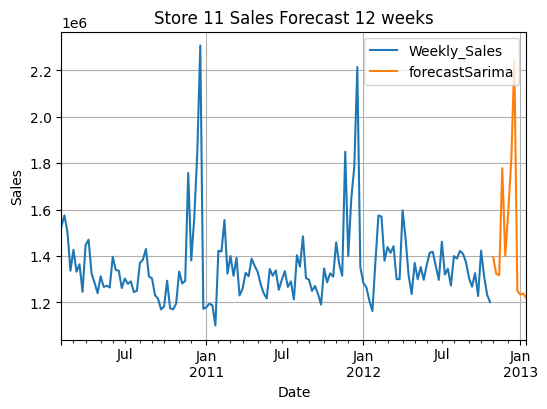

In [23]:
predict_store_sales_sarimax(walmart, 11)

Conclusion from the Analysis : Using sarimax we are able to successfully predict the next 12 weeks data. From the above chart it is clear that the forecast has taken into account the trends and seasonality quite well to predict the future data